In [701]:
bar_x=[]
bar_y=[]

time_x=[]
time_y=[]

In [782]:
import time
!pip --version
import os
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklite import LazyExport


import json

import numpy as np
import seaborn as sns

# record start time
import pandas as pd
import torch
from IPython.core.display import display
from keras import layers
# residual block
# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from general_model.grow_numpy import GrowableNumpyArray
from general_model.list_batch_loader import ListBatchLoadDataset
from model_helper.single_gpu_dataloader import SingleGpuTensorWrapper
from pytorch_regression.regression_params import RegressionParams
from tool import ml, wine_tool, data_loader, wine_data_loader
from tool.dbg import dbg

pip 22.0.3 from D:\miniconda\envs\tf_gpu\lib\site-packages\pip (python 3.7)



In [783]:
x_all_pre, y_all_pre = wine_data_loader.get_data3(use_onehot=False)
x_all_pre.shape


(740, 1000)

# Agumented data

In [784]:
import random


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

class WineDataAugmentation:
    def __init__(self, xs: np.array, ys: np.array):
        self.xs = xs
        self.ys = ys


    def generate(self, size=2):
        new_size = self.xs.shape[0] * size
        # numpy拷贝xs和ys到size倍

        xs=np.repeat(self.xs, size, axis=0)
        ys=np.repeat(self.ys, size, axis=0)

        # xs [batch * 1000]
        # 对xs中的第一个维度随机乘以0.1-1.0之间的数
        xs = xs * np.random.uniform(0.9, 1.1, size=(new_size, 1))

        # 加入-300~300的噪音
        # noise = np.random.random((new_size, self.xs.shape[1]))
        # noise = noise * 10000
        # print(noise)
        # print(np.ptp(noise, axis=1).shape)
        # print(np.ptp(noise, axis=1))
        # return
        # xs = xs + noise
        # # 每个样本减去自己的最小值
        # xs = xs - np.min(xs, axis=1).reshape(-1, 1)
        dbg(xs.shape)

        for i in range(xs.shape[0]):
            this_tensor=xs[i]
            # r= random [-200,200]
            r=random.randint(-50,50)
            # r=random.randint(-500,500)
            # dbg(r)
            if r<0:
                r=-r
                xs[i][:1000-r]=this_tensor[r:1000]
                xs[i][1000-r:]=this_tensor[1000-r-1]
            else:
                xs[i][r:1000]=this_tensor[:1000-r]
                xs[i][:r]=this_tensor[r]
        # xs=xs[0:50]
        # xs=xs[50:100]
        # xs=xs[0:100]
        # dbg('0',xs[:,:5])
        # xs=shuffle_along_axis(xs, axis=0)
        # dbg('1',xs[:,:5])
        return xs, ys

In [785]:
# x_all_augmented,y_all_augmented = WineDataAugmentation(x_all_pre,y_all_pre).generate(1)
x_all_augmented,y_all_augmented = (x_all_pre,y_all_pre)
x_all_augmented.shape

(740, 1000)

In [786]:
x_all_pre.shape,y_all_pre.shape

((740, 1000), (740,))

In [787]:
_,_,x_all_pre_test,y_all_pre_test = wine_data_loader.split(x_all_pre,y_all_pre,0.2)
x_all_pre_test.shape,y_all_pre_test.shape

((148, 1000), (148,))

In [788]:
# for i in range(70,100,2):
#     plt.plot(x_all_pre[i],'b-')
#     plt.show()

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


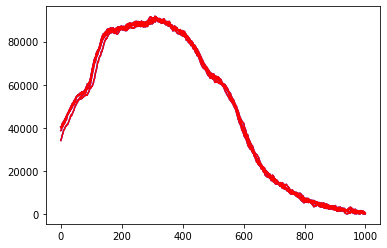

In [789]:
to_print=(35,40)
for i in range(*to_print):
    plt.plot(x_all_pre[i],'b-')
for i in range(*to_print):
    dbg(x_all_augmented[i].shape)
    plt.plot(x_all_augmented[i],'r-')
    # dbg(x_all_augmented[i])
# plt.plot(x_all_augmented[0],'r-')
# plt.plot(x_all_augmented[0]-x_all_pre[0],'g-')
plt.show()


In [790]:
y_all=y_all_augmented

PCA
-  or lda，处理x数据

In [791]:
# pca = PCA(n_components=5)
#
# # https://stackoverflow.com/questions/31107945/how-to-perform-prediction-with-lda-linear-discriminant-in-scikit-learn
# # fit fit_transform和transform的关系
# x_all = pca.fit_transform(x_all_augmented)
# print(x_all.shape)
# print(pca.explained_variance_ratio_)
#
# # history.history是个字典：列表的数据
# pd.DataFrame({
#     'pca': pca.explained_variance_ratio_,
# }).plot(figsize=(8, 5))
# plt.show()

LDA

In [792]:
x_all_augmented_train,y_all_augmented_train,x_all_augmented_test,y_all_augmented_test = wine_data_loader.split(x_all_augmented,y_all_augmented, 0.2)

(592, 5)
[0.36884992 0.18429756 0.14095551 0.12337017 0.07883306]


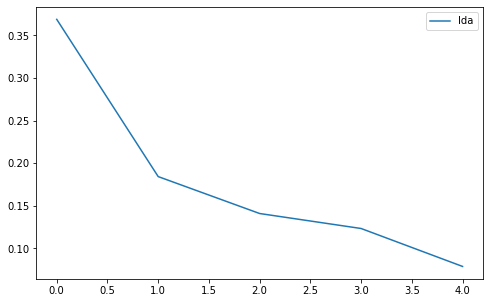

In [793]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=5)

# https://stackoverflow.com/questions/31107945/how-to-perform-prediction-with-lda-linear-discriminant-in-scikit-learn
# fit fit_transform和transform的关系
lda = lda.fit(x_all_augmented_train,y_all_augmented_train)
x_all = lda.transform(x_all_augmented_train)

x_test = lda.transform(x_all_pre_test)

print(x_all.shape)
print(lda.explained_variance_ratio_)
pd.DataFrame({
    'lda': lda.explained_variance_ratio_,
}).plot(figsize=(8, 5))
plt.show()

x,y,x1,y1 = x_all,y_all_augmented_train,x_test,y_all_pre_test

# train test split

In [794]:
# x, y, x1, y1 = wine_data_loader.split(x_all,y_all, 0.2)


In [795]:
# bar_x=[]
# bar_y=[]
#
# time_x=[]
# time_y=[]


In [796]:
x.shape

(592, 5)

In [797]:
# augmentation
# repeats = 50
# x=np.repeat(x,repeats,axis=0)
# y=np.repeat(y,repeats,axis=0)

In [798]:
y.shape

(592,)

# SVC MODEL

In [799]:
y.dtype

dtype('int32')

In [800]:
clf = SVC()
clf.fit(x, y)
start = time.time()
val_results=clf.predict(x1)
end = time.time()
time_x.append('SVM')
time_y.append(end-start)
svm_score=(np.average(val_results.astype(int)==y1.astype(int)))
svm_score
# val_results

0.9121621621621622

In [801]:
bar_x.append('SVM')
bar_y.append(svm_score)

In [802]:
lazy = LazyExport(clf)

model_save_path='model/svciris.json'
if os.path.exists(model_save_path):
    os.remove(model_save_path)
lazy.save(model_save_path)


# knn model

In [803]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x,y)

start=time.time()
val_results=knn.predict(x1)
end=time.time()
time_x.append('KNN')
time_y.append(end-start)
knn_time=end-start

# val_results

In [804]:
knn_score=(np.average(val_results.astype(int)==y1.astype(int)))
knn_score

0.9121621621621622

In [805]:
# lazy = LazyExport(knn)
#
# model_save_path='model/knn.json'
# if os.path.exists(model_save_path):
#     os.remove(model_save_path)
# lazy.save(model_save_path)

## why not knn?(用来提出我们的深度学习模型)

参数量过大，加载时间太长

如果把参数量降低到，60组数据时，精确度大概降低到了90左右，但是即使如此，参数在6万左右


In [806]:
# knn_json=ml.read_json('model/knn.json')
# 'knn length ',knn_json['_fit_X'].__len__() # shape [666,1000]

In [807]:
bar_x.append('KNN')
bar_y.append(knn_score)

# xgboost model


In [808]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(x, y)

start=time.time()
val_results = xgb_model.predict(x1)
end=time.time()
time_x.append('XGB')
time_y.append(end-start)

D:\miniconda\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [809]:
xgb_score=(np.average(val_results.astype(int)==y1.astype(int)))
xgb_score

0.7567567567567568

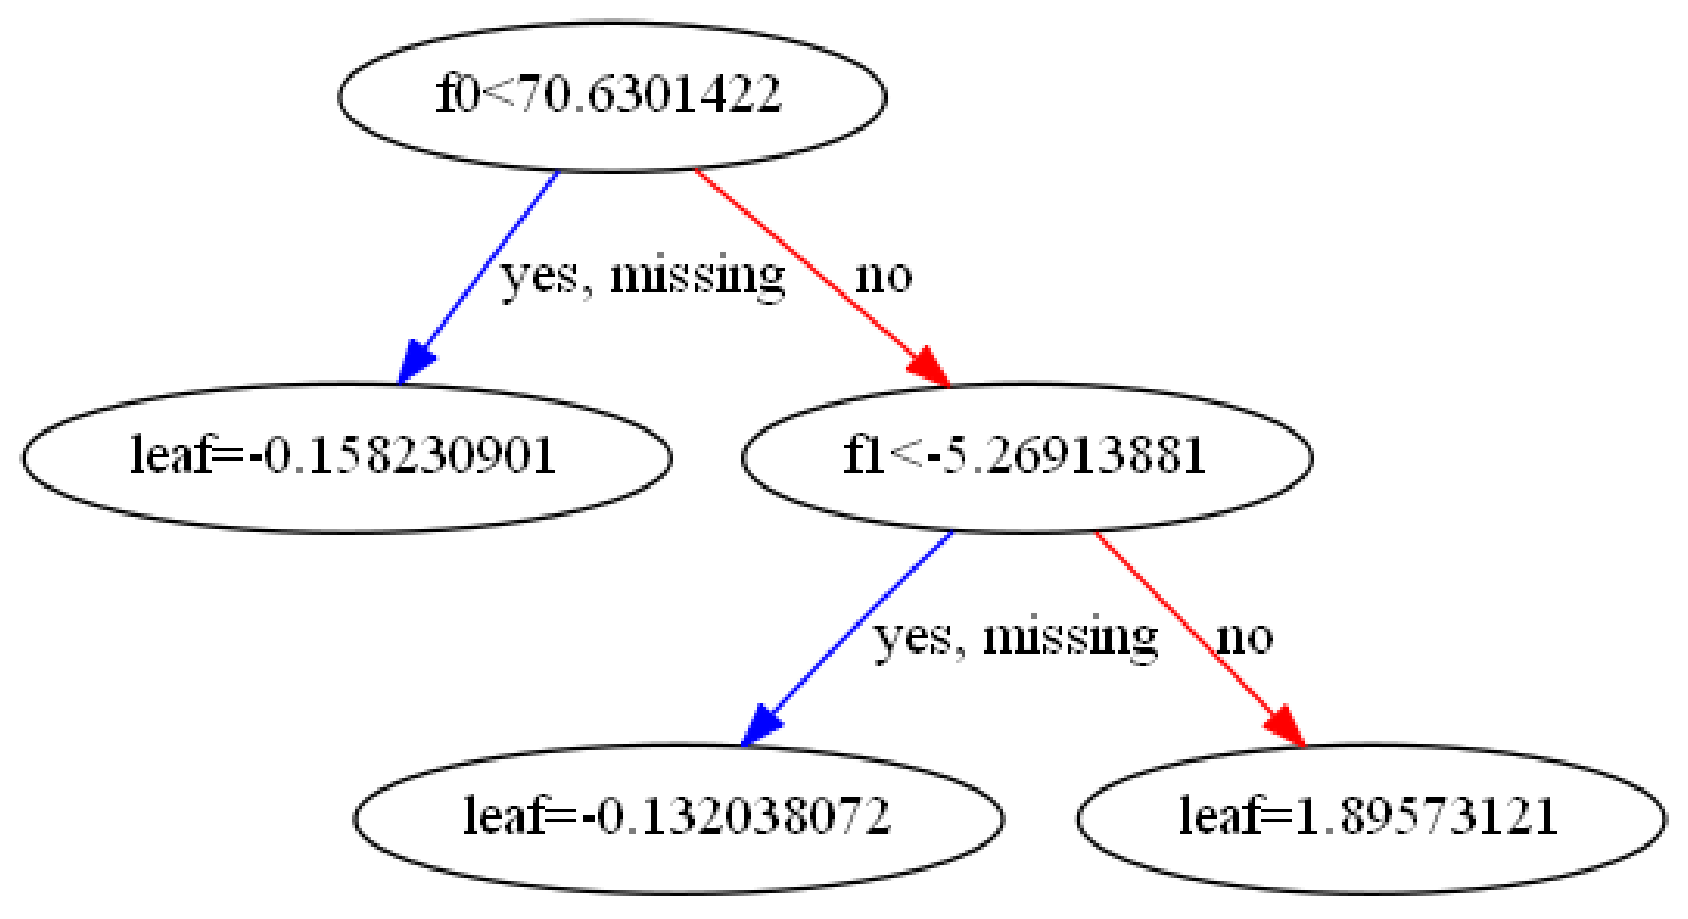

In [810]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xgb_model, num_trees=4, ax=ax)
plt.show()

In [811]:
bar_x.append('XGB')
bar_y.append(xgb_score)

# Neural Network

In [812]:
# tf.debugging.set_log_device_placement(True)
tf.debugging.set_log_device_placement(False)

In [813]:
x_all_augmented_test.shape

(148, 1000)

In [814]:
new_model = tf.keras.models.load_model('model/tf_fcl.h5')
start= time.time()
prediction=new_model.predict(x_all_pre_test)
end=time.time()
time_x.append('NN')
time_y.append(end-start)

bar_x.append('NN')
bar_y.append(np.average(tf.argmax(prediction, axis=1)==y_all_pre_test))
np.average(tf.argmax(prediction, axis=1)==y_all_pre_test)


0.972972972972973

In [815]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


[(0.5, 1.0)]

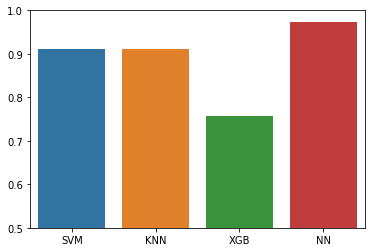

In [816]:
ax=sns.barplot(x=bar_x, y=bar_y)
ax.set(ylim=(0.5, 1))
# ax.set(ylim=(0.7, 1))

<AxesSubplot:>

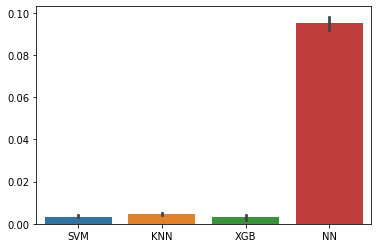

In [817]:
sns.barplot(x=time_x, y=time_y)

In [818]:
# import numpy as np
# a=np.zeros((100,))
# a.shape

In [819]:
# a[:40]=1

In [820]:
# from sklearn.cross_decomposition import PLSRegression
# X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
# Y = [1,2,3,4]
# pls2 = PLSRegression(n_components=1)
#
# Y_pred = pls2.fit_transform(X,Y)
#

In [821]:
# Y_pred